# Chinook, Business Questions, Analysis

Continuing on my previous work withe Chinook Database this project will focus on answering specific business realted questions and incorporate more python techniques.

Schema is below:

![img](https://s3.amazonaws.com/dq-content/191/chinook-schema.svg)

In [5]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

db = "chinook.db"

Create a run_query() function, that takes a SQL query as an argument and returns a pandas dataframe of that query.

In [6]:
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

Create a run_command() function that takes a SQL command as an argument and executes it using the sqlite module.

In [7]:
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

Create a show_tables() function that calls the run_query() function to return a list of all tables and views in the database.

In [8]:
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Select albums to purchase
The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name          |  Genre  |
|----------------------|---------|
| Regal	               | Hip-Hop |
| Red Tone	           | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites	   | Blues   |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

Find out which genres sell the most tracks in the USA

In [16]:
albums_purchased_usa = """
WITH usa_tracks_sold AS
(
    SELECT * FROM invoice_line AS il
    INNER JOIN invoice AS i
    ON il.invoice_id = i.invoice_id
    INNER JOIN customer AS c
    ON i.customer_id = c.customer_id
    WHERE c.country = "USA"
    )
    
SELECT
    g.name AS genre,
    COUNT(uts.invoice_line_id) AS track_sold,
    CAST(COUNT(uts.invoice_line_id) AS float) / 
    (SELECT COUNT(*) FROM usa_tracks_sold) AS percentage_sold
FROM usa_tracks_sold AS uts
INNER JOIN track AS t
    ON t.track_id = uts.track_id
INNER JOIN genre AS g
    ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
"""
    
run_query(albums_purchased_usa)

,genre,track_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


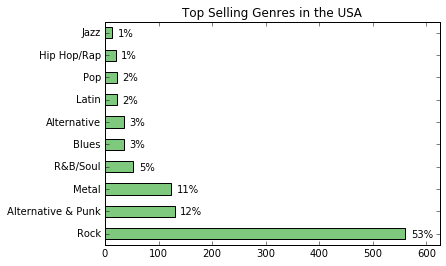

In [28]:
genre_sales_usa = run_query(albums_purchased_usa)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["track_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "track_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

We can see that the highest percetnage sold for album genres are Rock, Alternative & Punk and Metal. Rock has a significant portion of percetnage sold at over 50% of the entire tracks sold in the USA.

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)


--------------------------------------------------------------------------------

## Analyzing Employee Sales Performance
Analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [36]:
employee_sales_performance ="""
WITH customer_support_sales AS
    (
    SELECT
        c.customer_id,
        c.support_rep_id AS sales_agent,
        SUM(i.total) AS total_sales
    FROM customer AS c
    INNER JOIN invoice AS i
    ON c.customer_id = i.customer_id
    GROUP BY 1,2
    )
    
SELECT
    e.first_name || " " || e.last_name AS name,
    e.title,
    e.hire_date,
    SUM(css.total_sales) AS total_sales
FROM employee AS e
INNER JOIN customer_support_sales AS css
ON e.employee_id = css.sales_agent
GROUP BY 1;
"""

run_query(employee_sales_performance)

,name,title,hire_date,total_sales
0,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1731.51
1,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.00
2,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1393.92


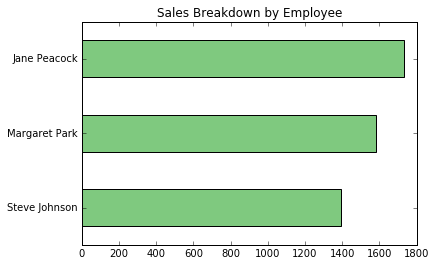

In [38]:
employee_sales = run_query(employee_sales_performance)

employee_sales.set_index("name", drop=True, inplace=True)
employee_sales.sort_values("total_sales", inplace=True)
employee_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Accent
)
plt.ylabel('')
plt.show()

Looking at this graph it is clear that Jane Peacock has the highest sales, but if we look at the query we ran earlier we can see that Steve Johnson almost 6 month after Jane. This can be an important factor in the difference in sales.

--------------------------------------------------------------------------------

## Analyzing Sales by Country

In [41]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line AS il
     INNER JOIN invoice AS i
         ON i.invoice_id = il.invoice_id
     INNER JOIN customer AS c 
         ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        COUNT(DISTINCT customer_id) AS customers,
        SUM(unit_price) AS total_sales,
        SUM(unit_price) / COUNT(DISTINCT customer_id) AS customer_lifetime_value,
        SUM(unit_price) / COUNT(DISTINCT invoice_id) AS average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


# Visualizing Sales by Country

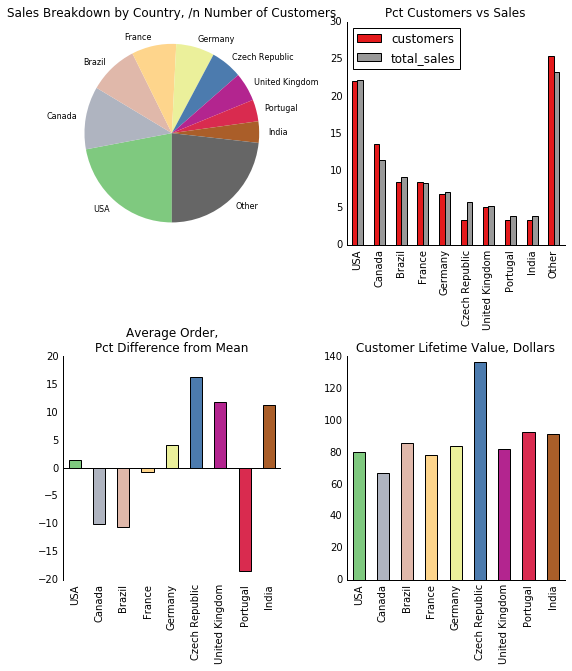

In [47]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

#Build subplot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

#top left
sales_breakdown = country_metrics["total_sales"].copy().rename("")
sales_breakdown.plot.pie(
    ax=ax1,
    startangle = -90,
    counterclock = False,
    title = "Sales Breakdown by Country, /n Number of Customers",
    colormap = plt.cm.Accent,
    fontsize = 8,
    wedgeprops = {"linewidth" :0}
)

# Top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the data, there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
- India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

## Albums vs Individual Tracks
Categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:

- Number of invoices
- Percentage of invoices

In [48]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.